Please note that the file libdevice.10.bc is only in the Titanic folder as a workaround to a bug. The file is not automatically found at its proper location (/usr/lib/cuda/nvvm/libdevice/libdevice.10.bc) so it is placed here instead.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [29]:
train = pd.read_csv("train.csv")
train = train.sample(frac=1)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
509,510,1,3,"Lang, Mr. Fang",male,26.0,0,0,1601,56.4958,NaN,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S
174,175,0,1,"Smith, Mr. James Clinch",male,56.0,0,0,17764,30.6958,A7,C
546,547,1,2,"Beane, Mrs. Edward (Ethel Clarke)",female,19.0,1,0,2908,26.0000,NaN,S
373,374,0,1,"Ringhini, Mr. Sante",male,22.0,0,0,PC 17760,135.6333,NaN,C


In [30]:
train["Embarked"].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [31]:
def normalise_age_and_fare(df: pd.DataFrame) -> pd.DataFrame: # Takes as argument the training dataframe and returns the same dataframe with the Age and Fare columns normalised and NaN entries filled.
    
    # Normalise the Age and Fare columns
    df.Age = (df.Age - df.Age.mean()) / df.Age.std()
    df.Fare = (df.Fare - df.Fare.mean()) / df.Fare.std()
    
    # Replace null age values with a random number sampled from the uniform distribution over [-1, +1] (this is mean +/- std of the ages)
    null_ages = np.isnan(df.Age)
    null_ages_count = len(null_ages)
    random_ages = np.random.random_sample(null_ages_count)
    random_ages = (random_ages - 0.5) * 2
    df.Age[null_ages] = random_ages
    
    return df

In [32]:
def preprocess_df(df: pd.DataFrame): # For training set, returns a cleaned training dataset as well as labels in their own dataframe. For test set, returns only cleaned dataset.
        
    # Map female -> 0 and male -> 1
    df["Sex"] = df["Sex"].map({"female": 0,
                               "male": 1})

    # In "Embarked" column there are {S:644, C:168, Q:77, NaN:2} so we map S -> 0, C -> 1, Q -> 2, NaN -> 0
    embarked_map = {"S": 0,
                    "C": 1,
                    "Q": 2}

    df["Embarked"] = df["Embarked"].map(embarked_map)
    df.Embarked = df.Embarked.fillna(0)

    # Remove categories that don't correspond to survival rate.
    df = df.drop("PassengerId", axis=1)
    df = df.drop("Name", axis=1)
    df = df.drop("Ticket", axis=1)
    df = df.drop("Cabin", axis=1)
    
    df = normalise_age_and_fare(df)

    # If this is training set, shuffle everything and put labels in their own dataframe. If this is test set without labels, skip this step.
    if "Survived" in df:
        df = df.sample(frac=1) # Shuffles the samples for k-fold cross validation
        labels = df.pop("Survived")
        train = df
        return train, labels
    
    return df

In [33]:
df = pd.read_csv("train.csv")
train, labels = preprocess_df(df)

print(train.head(), labels.head())

     Pclass  Sex       Age  SibSp  Parch      Fare  Embarked
630       1    1  3.462699      0      0 -0.044356       0.0
712       1    1  1.259828      1      0  0.398358       0.0
364       3    1 -0.909092      1      0 -0.336145       2.0
563       3    1 -0.431385      0      0 -0.486064       0.0
861       2    1 -0.598845      1      0 -0.416639       0.0 630    1
712    1
364    0
563    0
861    0
Name: Survived, dtype: int64


/tmp/ipykernel_864/275173478.py:12: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.Age[null_ages] = random_ages
/tmp/ipykernel_864/275173478.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame


In [34]:
def build_model():
    model = keras.Sequential([
        layers.Dense(256, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=keras.optimizers.RMSprop(0.01),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [35]:
# Implement k-fold validation
k = 5
num_val_samples = len(train) // k
num_epochs = 9
all_histories = []
for i in range(k):
    print(f"Processing fold #{i}")
    
    val_data = train[i * num_val_samples: (i + 1) * num_val_samples]
    val_labels = labels[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train[:i * num_val_samples],
         train[(i + 1) * num_val_samples:]],
        axis=0
    )
    
    partial_train_labels = np.concatenate(
        [labels[:i * num_val_samples],
         labels[(i + 1) * num_val_samples:]],
        axis=0
    )
    
    model = build_model()
    
    history = model.fit(
        partial_train_data,
        partial_train_labels,
        epochs=num_epochs,
        validation_data=(val_data, val_labels),
        verbose=0
    )
    
    all_histories.append(history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


In [9]:
# Average the training and validation accuracy for each epoch across the folds
avg_val_accuracy = np.empty((k,num_epochs))
avg_train_accuracy = np.empty((k,num_epochs))
for i in range(k):
    avg_val_accuracy[i,:] = all_histories[i].history["val_accuracy"]
    avg_train_accuracy[i,:] = all_histories[i].history["accuracy"]
avg_val_accuracy = avg_val_accuracy.mean(axis=0)
avg_train_accuracy = avg_train_accuracy.mean(axis=0)

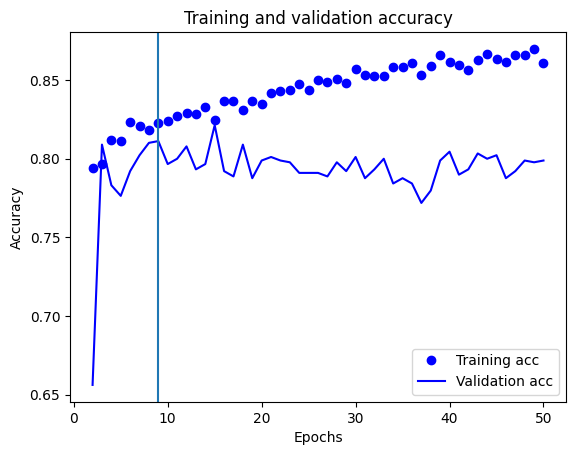

In [16]:
cut = 1
epochs = range(cut+1, num_epochs + 1)
plt.plot(epochs, avg_train_accuracy[cut:], "bo", label="Training acc")
plt.plot(epochs, avg_val_accuracy[cut:], "b", label="Validation acc")
plt.axvline(9)
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [36]:
test = pd.read_csv("test.csv")
PassengerId = test["PassengerId"].values
test = preprocess_df(test)

/tmp/ipykernel_864/275173478.py:12: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.Age[null_ages] = random_ages
/tmp/ipykernel_864/275173478.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame


In [37]:
predictions = model.predict(test)

# Convert all predictions to 0 or 1
for i in range(len(predictions)):
    if predictions[i] < 0.5:
        predictions[i] = 0
    else:
        predictions[i] = 1

predictions = predictions.astype(int) # The submission format requires integers.
predictions = predictions.flatten() # This turns predictions into a 1D array that can be put into a dataframe.
        
data = {'PassengerId': PassengerId,
        'Survived': predictions}

prediction_df = pd.DataFrame(data)
prediction_df.tail()

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


,PassengerId,Survived
413,1305,0
414,1306,1
415,1307,0
416,1308,0
417,1309,0


In [38]:
prediction_df.to_csv("predictions.csv", index=False)